In [2]:
import numpy as np
import random,sys
from collections import defaultdict
import copy
from matplotlib import pyplot as plt
import collections
class Node(object):
    def __init__(self):
        self.value = None
        self.right = None
        self.left = None
        self.leaf = False
        self.leaf_list = None

In [31]:
import pandas as pd

1. Generating Decision Trees


Question 1.1 For a given value of k;m, (number of features, number of data points), write a function to generate a training data set based on the above scheme.


In [5]:
#Generate randomly the value of x0 with equal probability
def get_x1():
    return np.random.choice(np.arange(0,2), p=[0.5, 0.5])

def get_x(x):
    return np.random.choice(np.array([x,1-x]), p=[0.75, 0.25])

def get_w(i,k):
    return (0.9**i)/sum([0.9**j for j in range(2,k+1)])

def get_wvalues(k):
    return [ get_w(i,k) for i in range(2,k+1) ]

#create dataset of x values given k
def get_xvalues(k):
    x_values = np.empty(k,dtype=int)
    x1 = get_x1()
    x_values[0] = x1
    for i in range(1,k):
        x_values[i] = get_x(x_values[i-1])
    return x_values

#Getting the value of y based on x_values for a given k
def get_y(k): 
    x_values = get_xvalues(k)
    w_values = [0] + get_wvalues(k)
    if sum([x*w for x,w in zip(x_values,w_values)]) >= 0.5:
        return x_values[0], x_values
    else:
        return 1-x_values[0], x_values

#data set structure List(List(features+label)). Note: label is last element of the row. 
def create_training_data(k,m):
    y_values = []
    mat = np.empty([m,k+1],dtype=int)
    for i in range(0,m):
        y,x_val = get_y(k)
        y_values.append(y) 
        mat[i,:] = np.append(x_val,y)
    return mat, y_values

#finding majority element in the list
def majority_ele(l):
    for i,c in collections.Counter(l).most_common(1):
        return i

In [8]:
# Question1.2

"""
Frequency distribution of values in a given array
"""
def get_freq_dist(array):
    #sum of array gives number of rows with label x = 1
    freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
    freq_of_one = freq_of_one_1 if freq_of_one_1 != 0 else np.finfo(float).eps
    freq_of_zero = 1 - freq_of_one       
    return freq_of_one, freq_of_zero


"""
Calculating conditional probabilities. Eg: P(y=0|x=1)
Output: Dictionary of combinations of x and y with frequency
"""
def cond_prob(column,data):
    col = data[:,column]
    labels = data[:,-1]
    freq_pair = defaultdict(int)
    len_data = len(col)
    freq_one, freq_zero = sum(col), len_data -sum(col)
    for c,l in zip(col,labels):
        if c == 0:
            if freq_zero == 0: #to handle if none of the x value os equal to 0
                    freq_pair[(c,l)] += np.finfo(float).eps
            else:
                freq_pair[(c,l)] += 1/freq_zero
        else:
            if freq_one == 0: #to handle if none of the x value os equal to 0
                    freq_pair[(c,l)] += np.finfo(float).eps
            else:
                freq_pair[(c,l)] += 1/freq_one
    tot_labels = [(1,1),(1,0),(0,0),(0,1)]
    for key in tot_labels: #if key is missing, add a episilon value
        if key not in freq_pair.keys():
            freq_pair[key] = np.finfo(float).eps
    return freq_pair

"""
Calculating entroy of y
"""
def entropy_y(y_values):
    freq_of_one, freq_of_zero = get_freq_dist(y_values)
    return -freq_of_one*np.log2(freq_of_one)-freq_of_zero*np.log2(freq_of_zero)


"""
Calculating information gain for a feature given its labels.
Input: Training data, labels, feature vector
Output: index of the feature vector which has maximum information gain
"""
def calc_IG(data,y_values,feature_vec):
    entropy_y_all = entropy_y(y_values)
    y_freq_of_one, y_freq_of_zero = get_freq_dist(y_values)
    IG_for_x = []
    
    for i in range(0,len(feature_vec)):
        freq_of_one, freq_of_zero = get_freq_dist(data[:,i])
        freq_pair = cond_prob(i,data)
        x_0_y_0,x_0_y_1 = freq_pair[(0,0)],freq_pair[(0,1)]
        x_1_y_0,x_1_y_1 = freq_pair[(1,0)],freq_pair[(1,1)]
        ent_x_one  = -x_1_y_1*np.log2(x_1_y_1)-x_1_y_0*np.log2(x_1_y_0)
        ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)
        entroy_y_x = freq_of_zero*ent_x_zero + freq_of_one*ent_x_one
        IG_for_x.append(entropy_y_all - entroy_y_x)
    max_ig_x = np.argmax(IG_for_x)
    return max_ig_x, IG_for_x[max_ig_x]


In [9]:
"""
Creation of decision tree. Metric used to decide the featre for splitting is Information gain.
Input:Training data, labels, feature vector
Output: Decision tree node. Class node is defined at the start.
"""
def decision_tree(data_set, labels, feature_vec):
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1:
        flag = 1
        root.val = labels[0]
        root.leaf = True
        return root
    
    #Feature on which splitting will be done
    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    #  print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    #Setting the value to root which has maximum information gain
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = feature_vec[:max_ig_ind] + feature_vec[max_ig_ind+1:]
    
    #Splitting the the label value of choose feature.
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]

    # recursively calling the left and right split to create the decision tree
    if len(list(set(labels))) != 1: 
        flag = 1
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree(data_right,labels_right,new_feature_vec_right)
        if len(data_left):
            root.left = decision_tree(data_left,labels_left,new_feature_vec_left)
    return root
  

In [10]:
"""
Print the decision tree based on level order traversal. 
Input: Root decision tree node
Output: List with the data structure [ [ level, node value, parent, if it is root node or nor] ]
"""
def print_decision_tree(n):
    res = []
    queue = []
    #each level order traversal node is set as (level_of tree, node_val/feature,parent,if its leaf node)
    queue.append((-1, n, None, False))
    while len(queue) >0:
        level = []
        for i in range(len(queue)):    
            h,n,par,leaf = queue.pop(0)
            level.append((h+1,n.val,par,n.leaf))
            if n.left:
                queue.append((h+1, n.left,n.val,n.leaf))
            if n.right:
                queue.append((h+1, n.right,n.val,n.leaf))
        res.append(level)
    return res

In [160]:
def get_accuracy(org_dec,pred_dec):
    correct = 0
    for o,p in zip(org_dec,pred_dec):
        if o == p:
            correct += 1
    return correct/len(org_dec)

def get_error(org_dec,pred_dec):
    wrong = 0
    for o,p in zip(org_dec,pred_dec):
        if o != p:
            wrong += 1
    return wrong/len(org_dec)

def get_train_error(data_set,node):
    m = len(data_set)
    predicted_labels = []
    for r in range(0,m):
        predicted_labels.append(find_decision(data_set[r],node))

    return get_error(labels,predicted_labels)

#Generating data miultiple times and getting average error for "i" iterations
def avg_error(i,node_org,k=0):
    error = []
    iterations =  i
    m_list = []
    while i:
        node = copy.deepcopy(node_org)
        m=random.randint(10,100)
        if k ==0:
            k = random.randint(2,int(m/4))
        data_set, labels = create_training_data(k,m)
        # print('data set generated is the following: \n',data_set)
        predicted_labels = []
        for r in range(0,m):
#             print(len(data_set[0]))
            predicted_labels.append(find_decision(data_set[r],node))
        
        error.append(get_error(labels,predicted_labels))
        m_list.append(m)
        i -= 1
    return sum(error)/iterations, error, m_list


#row is the feature vector and node is root of decision tree
def find_decision(row,node):
    if node.leaf == True:
        return node.val
    while node.leaf != True:
        feature = node.val
        if row[feature] == 0:
            if node.left == None:
                return node.val
            node = node.left
        else:
            if node.right == None:
                return node.val
            node = node.right
    return node.val

Question 1. 2:
funtion decision_tree () will generate the decision tree. 
to print the decision tree, use function print_dec_tree with the parameters as first node.

Training error for this decision tree will be 0 since we are not early terminating it. 


In [159]:
#creating data with k = 4, m =10
train_data_set, train_labels = create_training_data(4,10)
train_feature_vec = list(range(0,4))
#Fitting the data to decision tree
node_train = decision_tree(train_data_set,train_labels,train_feature_vec)
train_pred_labels = []
for r in range(0,10):
    node_train_copy = copy.deepcopy(node_train)
    train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
train_error = get_error(train_labels,train_pred_labels)
print("Training error for the test data set created is: ",train_error)

Training error for the test data set created is:  0.0


Question 1.3

Ordering of the variables makes sense. The higher the information gain from the variable it will be on the top. 

In [12]:
#Question 1.3
k=4
m=30
data_set_org, labels = create_training_data(k,m) #Generating data
feature_vec = list(range(0,k)) #taking the values from 0 to k-1 as k-features
data_set = copy.deepcopy(data_set_org) #just keep old data for testing. can avoid it.
node_stat = decision_tree(data_set,labels,feature_vec)
node = copy.deepcopy(node_stat)
print_decision_tree(node)

[[(0, 0, None, False)],
 [(1, 2, 0, False), (1, 2, 0, False)],
 [(2, 1, 2, True), (2, 3, 2, False), (2, 0, 2, True), (2, 1, 2, True)],
 [(3, 1, 3, False), (3, 0, 3, True)],
 [(4, 1, 1, True), (4, 0, 1, True)]]

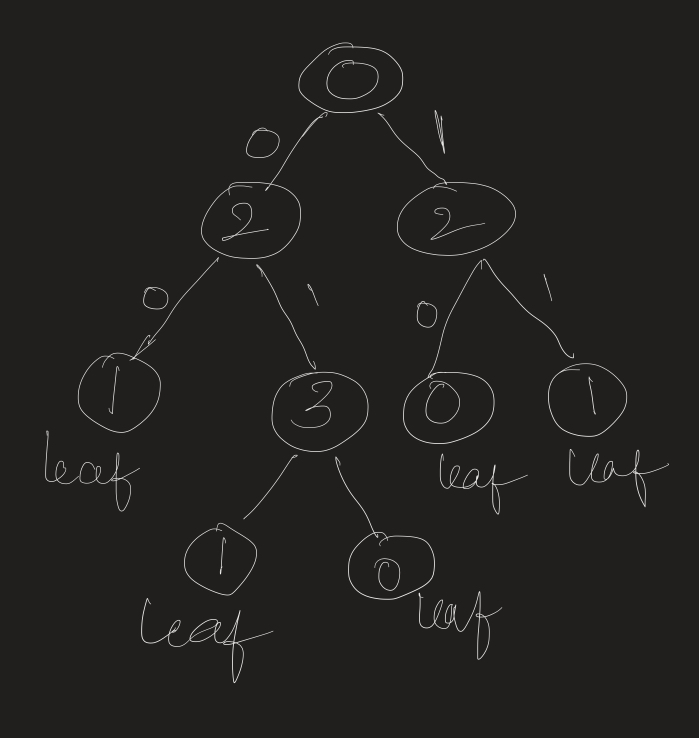

Question 1.4
Here I have generated k = 10 and random m value between 100 and 10000. Iterations in the below box is number of m values taken. Output is average error for the given k and m

In [13]:
#Q 1.4

iterations = 10
avg_error1iter, _, _= avg_error(iterations,node,k)
print("average error for ",iterations,"iterations is ",avg_error1iter)

average error for  10 iterations is  0.02328914732104958


Question 1.5

In the graph, you can see that as the value of m increaes, typical error decreases. Marginal value of addition of training data is beneficial for training only to a point. 

Text(0, 0.5, 'Abs error')

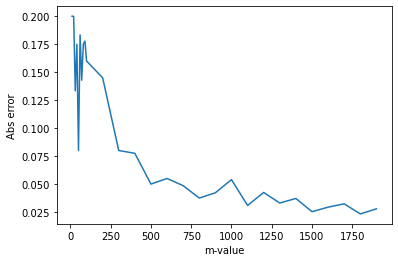

In [14]:
#Question 5

"""
Creating different values of m between 10 and 2000
"""
def get_m_list(x,y):
    m1 = list(range(10,100,10))
    m2 = list(range(100,2000,100))
    m3 = []#list(range(1000,10000,1000))
    m_list = m1 + m2 + m3
    return m_list

"""
Estimating error for multiple values of m
Output: average error for the given m and its error value as lists. 
"""
def avg_error_per_m(k=4):
    error = []
    m_list = []
    predicted_labels = []
    
    m_list = get_m_list(100,10000)
    k =10
    for m in m_list:
        
        train_data_set, train_labels = create_training_data(k,m)
        train_feature_vec = list(range(0,k))
        node_train = decision_tree(train_data_set,train_labels,train_feature_vec)
        train_pred_labels = []
        for r in range(0,m):
            node_train_copy = copy.deepcopy(node_train)
            train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
        train_error = get_error(train_labels,train_pred_labels)
        if train_error != 0:
            print("Error occured. Training error should be zero for m is ",m," /n")
        
        data_set, labels = create_training_data(k,m)
        predicted_labels = []
        for r in range(0,m):
            node_test_copy = copy.deepcopy(node_train)
            predicted_labels.append(find_decision(data_set[r],node_test_copy))
        test_error = get_error(labels,predicted_labels)
        abs_error = abs(train_error-test_error)
        error.append(abs_error)
    return sum(error)/len(m_list), error, m_list


avg_typical_error, abs_error, m_list= avg_error_per_m()
#plotting the graph for all iterations
plt.plot(m_list,abs_error)
plt.xlabel("m-value")
plt.ylabel("Abs error")

Question 1.6

Alternate metric used inplace of information_gain is gini index. From the below graph of comparison for gini vs ig we can see that both the indecies show similar behaviour. 

In [169]:
"""
From the definition of gini index, the following method is written.
Input: Dataset, labels, featur_vector
Output: index of the feature vector with highest gini index. 
"""
def calc_gini(data,y_values,feature_vec):
    gini_for_x = []
    for i in range(0,len(feature_vec)):
        freq_of_one, freq_of_zero = get_freq_dist(data[:,i])
        freq_pair = cond_prob(i,data)
        x_0_y_0,x_0_y_1 = freq_pair[(0,0)],freq_pair[(0,1)]
        x_1_y_0,x_1_y_1 = freq_pair[(1,0)],freq_pair[(1,1)]
        gini_x_0 = 1 - x_0_y_0**2 - x_0_y_1**2
        gini_x_1 = 1 - x_1_y_0**2 - x_1_y_1**2
        gini = freq_of_one*gini_x_1 + freq_of_zero*gini_x_0
        gini_for_x.append(gini)
    max_gini_x = np.argmax(gini_for_x)
    return max_gini_x, gini_for_x[max_gini_x]


"""
Decision tree creation using gini index.
Input  : Training_data, labels, feature_vector
Output : Root node of the decision tree 
"""
def decision_tree_gini(data_set, labels, feature_vec):
#     print(labels,"feature vectors before splitting the tree",feature_vec)
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1:
        flag = 1
        root.val = labels[0]
        root.leaf = True
        return root    

    max_ig_ind, maxGain = calc_gini(data_set,labels,feature_vec)
    #  print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = feature_vec[:max_ig_ind] + feature_vec[max_ig_ind+1:]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]

    if len(list(set(labels))) != 1:
        flag = 1
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree(data_right,labels_right,new_feature_vec_right)
        if len(data_left):
            root.left = decision_tree(data_left,labels_left,new_feature_vec_left)
    return root

"""
Calculating the average error for different m values from 100 to 10000
"""
def avg_error_per_m_gini(k=4):
    error = []
    m_list = []
    predicted_labels = []
    
    m_list = get_m_list(100,10000)
    k =10
    for m in m_list:
        
        train_data_set, train_labels = create_training_data(k,m)
        train_feature_vec = list(range(0,k))
        node_train = decision_tree_gini(train_data_set,train_labels,train_feature_vec)
        train_pred_labels = []
        for r in range(0,m):
            node_train_copy = copy.deepcopy(node_train)
            train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
        train_error = get_error(train_labels,train_pred_labels)
        if train_error != 0:
            print("Error occured. Training error should be zero for m is ",m," /n")
        
        data_set, labels = create_training_data(k,m)
        predicted_labels = []
        for r in range(0,m):
            node_test_copy = copy.deepcopy(node_train)
            predicted_labels.append(find_decision(data_set[r],node_test_copy))
        test_error = get_error(labels,predicted_labels)
        abs_error = abs(train_error-test_error)
        error.append(abs_error)
    return sum(error)/len(m_list), error, m_list


avg_typical_error_gini, abs_error_gini, m_list_gini= avg_error_per_m_gini()


[0.3,
 0.2,
 0.26666666666666666,
 0.175,
 0.22,
 0.21666666666666667,
 0.15714285714285714,
 0.1125,
 0.15555555555555556,
 0.1,
 0.085,
 0.06666666666666667,
 0.09,
 0.058,
 0.051666666666666666,
 0.047142857142857146,
 0.05125,
 0.034444444444444444,
 0.033,
 0.04090909090909091,
 0.034166666666666665,
 0.026153846153846153,
 0.027857142857142858,
 0.027333333333333334,
 0.02875,
 0.021176470588235293,
 0.021111111111111112,
 0.030526315789473683]

Text(0, 0.5, 'Abs error')

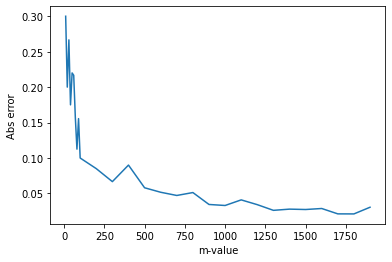

In [172]:
#plotting the graph for all iterations
plt.plot(m_list_gini,abs_error_gini)
plt.xlabel("m-value")
plt.ylabel("Abs error")


In [174]:
#Comparision between IG and gini index
df = pd.DataFrame({'x':m_list, 'y1': abs_error, 'y2':abs_error_gini})


plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
plt.xlabel("m-value")
plt.ylabel("error_value")
plt.legend()
print("y1->train_error y2->test_error")
for tr,te,d in zip(abs_error,abs_error_gini,m_list):
    print("for depth: ",d," training error is: ",tr)

Question2:

Question2.1
I used the new distribution given by the professor on canvas. There are irrelevant variables selected as splliting features. There should be terminating conditions for the same. 

In [144]:
#Generate randomly the value of x0 with equal probability
def get_x1_2():
    return np.random.choice(np.arange(0,2), p=[0.5, 0.5])

def get_x_2(x):
    return np.random.choice(np.array([x,1-x]), p=[0.75, 0.25])

def get_xvalues_2(k):
    x_values = np.empty(k,dtype=int)
    x1 = get_x1_2()
    x_values[0] = x1
    for i in range(1,10):
        x_values[i] = get_x_2(x_values[i-1])
    for i in range(11,16):
        x_values[i] = get_x1_2()
    return x_values

#According to the distribution, label value is dependent on value of x0, x1-x5,x6-x10
def get_y_2(k=16):
    x_values = get_xvalues_2(k)
    if x_values[0] == 0:
        return majority_ele(x_values[1:6]), x_values
    else:
        return majority_ele(x_values[6:11]), x_values


#data set structure List(List(features+label)). Note: label is last element of the row. 
def create_training_data_2(k,m):
    y_values = []
    mat = np.empty([m,k+1],dtype=int)
    for i in range(0,m):
        y,x_val = get_y_2(k)
        y_values.append(y) 
        mat[i,:] = np.append(x_val,y)
    return mat, y_values


"""
Decision Tree with irrelevant noise carrying at each step.
Output: Root node and irralevant variables choosen as nodes in the tree.
"""
def decision_tree_2(data_set, labels, feature_vec,irr_var=[]):
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1:
        flag = 1
        root.val = labels[0]
        root.leaf = True
        return root, irr_var
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    set_features = set(feature_vec)
    if feature_vec[max_ig_ind] in list(range(11,16)):
        irr_var.append(feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = feature_vec[:max_ig_ind] + feature_vec[max_ig_ind+1:]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
    if len(list(set(labels))) != 1:
        flag = 1
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right,irr_var = decision_tree_2(data_right,labels_right,new_feature_vec_right,irr_var)
        if len(data_left):
            root.left,irr_var = decision_tree_2(data_left,labels_left,new_feature_vec_left,irr_var)
    return root, irr_var

m_2 = 100
k=16
#Creating the data
data_set_org_2,labels_2 = create_training_data_2(16,m_2)
feature_vec_2 = list(range(0,k)) #taking the values from 0 to k-1 as k-features
data_set_2 = copy.deepcopy(data_set_org_2) #just keep old data for testing. can avoid it.

#Function tofit the tree using ID3
node_stat_2,irr_var = decision_tree_2(data_set_2,labels_2,feature_vec_2)
node_2 = copy.deepcopy(node_stat_2)

#printing the decision tree
# print_decision_tree(node_2)





<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)


<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)
<ipython-input-8-7c793c88cc47>:5: RuntimeWarning: overflow encountered in long_scalars
  freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
<ipython-input-8-7c793c88cc47>:15: RuntimeWarning: overflow encountered in long_scalars
  freq_one, freq_zero = sum(col), len_data -sum(col)


Text(0, 0.5, 'Abs error')

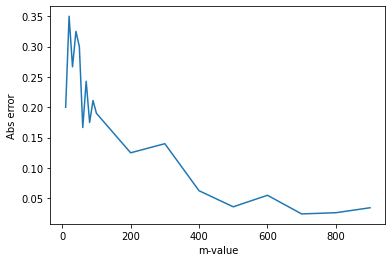

In [146]:
def get_m_list_21(x,y):
    m1 = list(range(10,100,10))
    m2 = list(range(100,1000,100))
    m3 = []#list(range(1000,10000,1000))
    m_list = m1 + m2 + m3
    return m_list

#Calculating average error for the trained data
def avg_error_per_m_2(k=16):
    error = []
    m_list = []
    predicted_labels = []
    
    m_list = get_m_list_21(100,10000)
    
    for m in m_list:
        
        train_data_set, train_labels = create_training_data_2(k,m)
        train_feature_vec = list(range(0,k))
        node_train,_ = decision_tree_2(train_data_set,train_labels,train_feature_vec)
        train_pred_labels = []
        for r in range(0,m):
            node_train_copy = copy.deepcopy(node_train)
            train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
        train_error = get_error(train_labels,train_pred_labels)
        if train_error != 0:
            print("Error occured. Training error should be zero for m is ",m," /n")
        
        data_set, labels = create_training_data_2(k,m)
        predicted_labels = []
        for r in range(0,m):
            node_test_copy = copy.deepcopy(node_train)
            predicted_labels.append(find_decision(data_set[r],node_test_copy))
        test_error = get_error(labels,predicted_labels)
        abs_error = abs(train_error-test_error)
        error.append(abs_error)
    return sum(error)/len(m_list), error, m_list


avg_typical_error, abs_error, m_list= avg_error_per_m_2()
#plotting the graph for all iterations
plt.plot(m_list,abs_error)
plt.xlabel("m-value")
plt.ylabel("Abs error")

Question 2.2

From the graph, as we increase the training data, we see the number of irrelevant data picked are less. In my experiments, after 10000 data points, error starts decreasing more. 

<ipython-input-8-7c793c88cc47>:5: RuntimeWarning: overflow encountered in long_scalars
  freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
<ipython-input-8-7c793c88cc47>:15: RuntimeWarning: overflow encountered in long_scalars
  freq_one, freq_zero = sum(col), len_data -sum(col)
<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)
<ipython-input-8-7c793c88cc47>:48: RuntimeWarning: invalid value encountered in log2
  ent_x_one  = -x_1_y_1*np.log2(x_1_y_1)-x_1_y_0*np.log2(x_1_y_0)


avg irrelavant variables used are 1.044117647058824


Text(0, 0.5, 'irr_var_count')

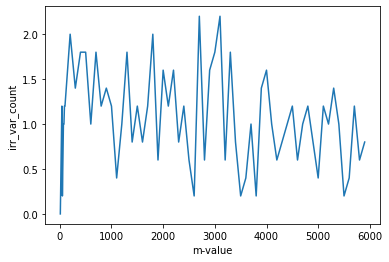

In [148]:
def get_m_list_22(x,y):
    m1 = list(range(10,100,10))
    m2 = list(range(100,6000,100))
    m_list = m1 + m2 
    return m_list

def avg_irr_var_per_m(iterations, k=16):
    m_list = get_m_list_22(100,10000)
    irr_var_list = []
    for m in m_list:
        avg_c = []
        for i in range(0,iterations):
            train_data_set, train_labels = create_training_data_2(k,m)
            train_feature_vec = list(range(0,k))
            node,_ = decision_tree_2(train_data_set,train_labels,train_feature_vec)
            _, irr_var = print_decision_tree_irr(node)
            avg_c.append(len(list(set(irr_var))))
        avg_count = sum(avg_c) / len(avg_c)
        irr_var_list.append(avg_count)
    return irr_var_list, m_list

def print_decision_tree_irr(n):
    res = []
    queue = []
    #each level order traversal node is set as (level_of tree, node_val/feature,parent,if its leaf node)
    queue.append((-1, n, None, False))
    irr = []
    while len(queue) >0:
        level = []
        for i in range(len(queue)):    
            h,n,par,leaf = queue.pop(0)
            if n.val in list(range(11,16)):
                irr.append(n.val)
            level.append((h+1,n.val,par,n.leaf))
            if n.left:
                queue.append((h+1, n.left,n.val,n.leaf))
            if n.right:
                queue.append((h+1, n.right,n.val,n.leaf))
        res.append(level)
    return res, irr

iterations = 5
irr_var_list, m_list= avg_irr_var_per_m(iterations)
avg_irr_var_used = sum(irr_var_list) / len(m_list)
print("avg irrelavant variables used are", avg_irr_var_used ) #Used decesion_tree_2 to get irrelevant variables
#plotting the graph for all iterations
plt.plot(m_list,irr_var_list)
plt.xlabel("m-value")
plt.ylabel("irr_var_count")


Question 2.3.a

From the below graph, you can see that at depth 6 the error becomes zero. Threshold is varing around 7/8/9 in my experiments according to the data. 

In [149]:
"""
depth: depth at which pruning is done
d    : depth of the current node
"""
def decision_tree_depth_prune(data_set, labels, feature_vec,depth,d=0):
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1 or d == depth:
        sum_labels =  sum(labels)
        rev_labels = len(labels) - sum_labels
        if sum_labels > rev_labels:
            root.val = 1
        else:
            root.val = 0
        root.leaf = True
        return root, d
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = feature_vec[:max_ig_ind] + feature_vec[max_ig_ind+1:]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
    if len(list(set(labels))) != 1:
        flag = 1
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right, d = decision_tree_depth_prune(data_right,labels_right,new_feature_vec_right,depth,d+1)
        if len(data_left):
            root.left, d = decision_tree_depth_prune(data_left,labels_left,new_feature_vec_left,depth,d+1)
    return root, d
  


def height_dt(n):
    res = []
    queue = []
    #each level order traversal node is set as (level_of tree, node_val/feature,parent,if its leaf node)
    queue.append((-1, n, None, False))
    
    while len(queue) >0:
        level = []
        for i in range(len(queue)):    
            h,n,par,leaf = queue.pop(0)
            level.append((h+1,n.val,par,n.leaf))
            if n.left:
                queue.append((h+1, n.left,n.val,n.leaf))
            if n.right:
                queue.append((h+1, n.right,n.val,n.leaf))
        res.append(level)
    return res, h+1

  

In [150]:
def prune_depth_iter(train_data_set, train_labels,test_data_set, test_labels,k=16):
    node_set = decision_tree(train_data_set,train_labels,list(range(0,16)))
    _,depth_set = height_dt(node_set)
    depth_set = depth_set 
    if depth_set == 0:
        return [],[],[]
    feature_vec = list(range(0,k))
    depths = list(range(1,depth_set))
    train_errors = []
    test_errors = []
    for depth in depths:
        node_train,_  = decision_tree_depth_prune(train_data_set, train_labels, feature_vec,depth,d=0)
        train_pred_labels = []
        for r in range(0,8000):
            node_train_copy = copy.deepcopy(node_train)
            train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
        train_error = get_error(train_labels,train_pred_labels)
        train_errors.append(train_error)
        
        test_predicted_labels = []
        for r in range(0,2000):
            node_test_copy = copy.deepcopy(node_train)
            test_predicted_labels.append(find_decision(test_data_set[r],node_test_copy))
        test_error = get_error(test_labels,test_predicted_labels)
        test_errors.append(test_error)
        
    return train_errors,test_errors, depths

# This data set is used for 2.3a,2.3b
train_data_set, train_labels = create_training_data_2(16,8000)
test_data_set, test_labels = create_training_data_2(16,2000)
train_errors,test_errors,depths = prune_depth_iter(train_data_set, train_labels,test_data_set, test_labels,k=16)



y1->train_error y2->test_error
for depth:  1  training error is:  0.161625
for depth:  2  training error is:  0.040375
for depth:  3  training error is:  0.010125
for depth:  4  training error is:  0.000125
for depth:  5  training error is:  0.0
for depth:  6  training error is:  0.000125
for depth:  7  training error is:  0.0


<ipython-input-152-478162899f2c>:4: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
<ipython-input-152-478162899f2c>:5: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)


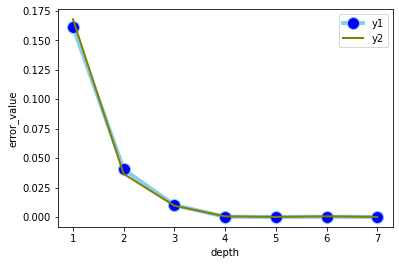

In [152]:
df = pd.DataFrame({'x':depths, 'y1': train_errors, 'y2':test_errors})


plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
plt.xlabel("depth")
plt.ylabel("error_value")
plt.legend()
print("y1->train_error y2->test_error")
for tr,te,d in zip(train_errors,test_errors,depths):
    print("for depth: ",d," training error is: ",tr)

Question 2.3.b
According to my experiments, threshold smaple size around 20-50. It is varying according to data. I ran experiment with threshold samplesize = 20 for 2.6 

In [153]:
def decision_tree_sample_size(data_set, labels, feature_vec,sample_size):
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1 or len(labels) <= sample_size:
        root.val = majority_ele(labels)
        root.leaf = True
        return root
    
    if feature_vec == []:
        print(feature_vec)
        print(labels)
    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)   
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = feature_vec[:max_ig_ind] + feature_vec[max_ig_ind+1:]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
    if len(list(set(labels))) != 1:
        flag = 1
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree_sample_size(data_right,labels_right,new_feature_vec_right,sample_size)
        if len(data_left):
            root.left = decision_tree_sample_size(data_left,labels_left,new_feature_vec_left,sample_size)
    return root



def prune_sample_size(train_data_set, train_labels,test_data_set, test_labels,k=16):
    m1 = list(range(10,100,10))
    m2 = list(range(100,1000,100))
    m3 = list(range(1000,10000,1000))
    m_list = m1 + m2 + m3
    train_errors = []
    test_errors = []
    for sample_size in m_list:
        node_train = decision_tree_sample_size(train_data_set, train_labels, list(range(0,16)),sample_size)
        train_pred_labels = []
        for r in range(0,8000):
            node_train_copy = copy.deepcopy(node_train)
            train_pred_labels.append(find_decision(train_data_set[r],node_train_copy))
        train_error = get_error(train_labels,train_pred_labels)
        train_errors.append(train_error)
        
        
        test_predicted_labels = []
        for r in range(0,2000):
            node_test_copy = copy.deepcopy(node_train)
            test_predicted_labels.append(find_decision(test_data_set[r],node_test_copy))
        test_error = get_error(test_labels,test_predicted_labels)
        test_errors.append(test_error)
        
        
    return train_errors,test_errors, m_list

# This data set is used for 2.3a,2.3b,2,5,2.6
train_data_set, train_labels = create_training_data_2(16,8000)
test_data_set, test_labels = create_training_data_2(16,2000)
train_errors,test_errors,m_list = prune_sample_size(train_data_set, train_labels,test_data_set, test_labels,k=16)

<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)


y1->train_error y2->test_error


<ipython-input-154-b767ac91b818>:4: RuntimeWarning: Second argument 'y1' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
<ipython-input-154-b767ac91b818>:5: RuntimeWarning: Second argument 'y2' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)


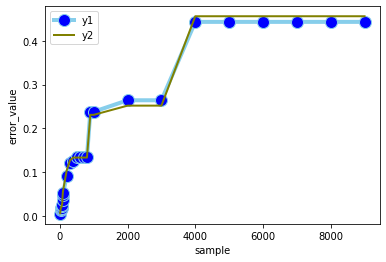

In [154]:

df = pd.DataFrame({'x':m_list, 'y1': train_errors, 'y2':test_errors})


plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
plt.xlabel("sample")
plt.ylabel("error_value")
plt.legend()
print("y1->train_error y2->test_error")

In [155]:
for tr,te,s in zip(train_errors,test_errors,m_list):
    print("Training error for pruned sample size: ",s, " is ",tr)

Training error for pruned sample size:  10  is  0.004875
Training error for pruned sample size:  20  is  0.013125
Training error for pruned sample size:  30  is  0.01625
Training error for pruned sample size:  40  is  0.018
Training error for pruned sample size:  50  is  0.018
Training error for pruned sample size:  60  is  0.022875
Training error for pruned sample size:  70  is  0.026
Training error for pruned sample size:  80  is  0.037625
Training error for pruned sample size:  90  is  0.048375
Training error for pruned sample size:  100  is  0.05325
Training error for pruned sample size:  200  is  0.091
Training error for pruned sample size:  300  is  0.12175
Training error for pruned sample size:  400  is  0.125875
Training error for pruned sample size:  500  is  0.13425
Training error for pruned sample size:  600  is  0.13425
Training error for pruned sample size:  700  is  0.13425
Training error for pruned sample size:  800  is  0.13425
Training error for pruned sample size:  90

Question2.5

Chose optimal depth as 7 from question 2.3a since at 7/8 depth, error becomes zero. As the datapoints increases , irrelevant variables decrease.

<ipython-input-8-7c793c88cc47>:5: RuntimeWarning: overflow encountered in long_scalars
  freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
<ipython-input-8-7c793c88cc47>:15: RuntimeWarning: overflow encountered in long_scalars
  freq_one, freq_zero = sum(col), len_data -sum(col)
<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)
<ipython-input-8-7c793c88cc47>:48: RuntimeWarning: invalid value encountered in log2
  ent_x_one  = -x_1_y_1*np.log2(x_1_y_1)-x_1_y_0*np.log2(x_1_y_0)


avg irrelavant variables used are 0.6638297872340425


Text(0, 0.5, 'irr_var_count')

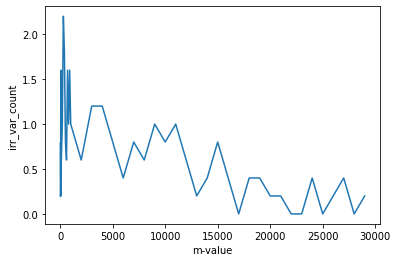

In [156]:
def get_m_list_25(x,y):
    m1 = list(range(10,100,10))
    m2 = list(range(100,1000,100))
    m3 = list(range(1000,30000,1000))
    m_list = m1 + m2 + m3 
    return m_list

def avg_irr_var_per_m_d(iterations, depth, k=16):
    m_list = get_m_list_25(100,10000)
    irr_var_list = []
    for m in m_list:
        avg_c = []
        for i in range(0,iterations):
            train_data_set, train_labels = create_training_data_2(k,m)
            
            train_feature_vec = list(range(0,k))
            node,_ = decision_tree_depth_prune(train_data_set,train_labels,train_feature_vec,depth)
            _, irr_var = print_decision_tree_irr(node)
            avg_c.append(len(list(set(irr_var))))
#         print("irr \n ",irr_var)
        avg_count = sum(avg_c) / len(avg_c)
        irr_var_list.append(avg_count)
    return irr_var_list, m_list

iterations = 5
optimal_depth = 8
irr_var_list, m_list= avg_irr_var_per_m_d(iterations,optimal_depth)
avg_irr_var_used = sum(irr_var_list) / len(m_list)
print("avg irrelavant variables used are", avg_irr_var_used ) #Used decesion_tree_2 to get irrelevant variables
#plotting the graph for all iterations
plt.plot(m_list,irr_var_list)
plt.xlabel("m-value")
plt.ylabel("irr_var_count")


Question 2.6.
Itook threshold value as 20. 
As the datapoints increases , irrelevant variables decrease.

<ipython-input-8-7c793c88cc47>:5: RuntimeWarning: overflow encountered in long_scalars
  freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
<ipython-input-8-7c793c88cc47>:15: RuntimeWarning: overflow encountered in long_scalars
  freq_one, freq_zero = sum(col), len_data -sum(col)
<ipython-input-8-7c793c88cc47>:49: RuntimeWarning: invalid value encountered in log2
  ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)


avg irrelavant variables used are 0.05172413793103448


Text(0, 0.5, 'irr_var_count')

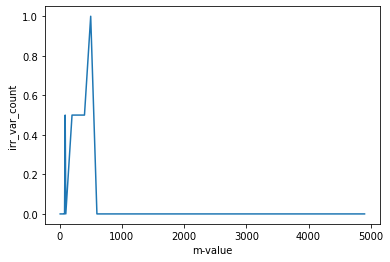

In [166]:
def get_m_list_26(x,y):
    m1 = list(range(10,100,10))
    m2 = list(range(100,5000,100))
    m3 = [] #list(range(1000,30000,1000))
    m_list = m1 + m2 + m3 
    return m_list

def avg_irr_var_per_m_ss(iterations, sampleSize,k=16):
    m_list = get_m_list_26(100,10000)
    irr_var_list = []
    for m in m_list:
        avg_c = []
        for i in range(0,iterations):
            train_data_set, train_labels = create_training_data_2(k,m)
            
            train_feature_vec = list(range(0,k))
            node = decision_tree_sample_size(train_data_set, train_labels, list(range(0,16)),sampleSize)
            _, irr_var = print_decision_tree_irr(node)
            avg_c.append(len(list(set(irr_var))))
#         print("irr \n ",irr_var)
        avg_count = sum(avg_c) / len(avg_c)
        irr_var_list.append(avg_count)
    return irr_var_list, m_list

iterations = 2
sampleSize = 20
irr_var_list, m_list= avg_irr_var_per_m_ss(iterations,sampleSize)
avg_irr_var_used = sum(irr_var_list) / len(m_list)
print("avg irrelavant variables used are", avg_irr_var_used ) #Used decesion_tree_2 to get irrelevant variables
#plotting the graph for all iterations
plt.plot(m_list,irr_var_list)
plt.xlabel("m-value")
plt.ylabel("irr_var_count")
